In [83]:
import sympy as sp
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm import tqdm
from matplotlib import pyplot as plt
from CommonFunctions import *
%matplotlib inline

# Harmonic oscillators

## Linear harmonic oscillator

$$ \alpha \frac{d^2x}{dt^2} + \beta \frac{dx}{dt} + \omega x = F \cos{\Omega t} $$

With initial conditions:

$$x(0) = 1, x'(0) = 0$$

In [112]:
t, alpha, beta, omega, F, Omega = sp.symbols('t alpha beta omega F Omega')
x = sp.Function('x')
diff_eq = sp.Eq(alpha * x(t).diff(t, 2) + beta*x(t).diff(t) + omega * x(t), F * sp.cos(Omega * t))
diff_eq

Eq(alpha*Derivative(x(t), (t, 2)) + beta*Derivative(x(t), t) + omega*x(t), F*cos(Omega*t))

In [153]:
alpha_val, beta_val, omega_val, F_val, Omega_val = 1, sp.Rational(1, 4), 1, 0.5, 0.15
beta_val_float = 1/4
x_eq = diff_eq.subs([(alpha, alpha_val), (beta, beta_val), (omega, omega_val), (F, F_val), (Omega, Omega_val)])
x_eq

Eq(x(t) + Derivative(x(t), t)/4 + Derivative(x(t), (t, 2)), 0.5*cos(0.15*t))

In [154]:
ics = {x(0): 5, x(t).diff(t).subs(t, 0): 0}
oscillator_sol = sp.dsolve(x_eq, x(t), ics=ics)
oscillator_sol

Eq(x(t), (0.562629048133535*sin(0.992156741649222*t) + 4.48924274685512*cos(0.992156741649222*t))*exp(-0.125*t) + 0.0195942680234609*sin(0.15*t) + 0.51075725314488*cos(0.15*t))

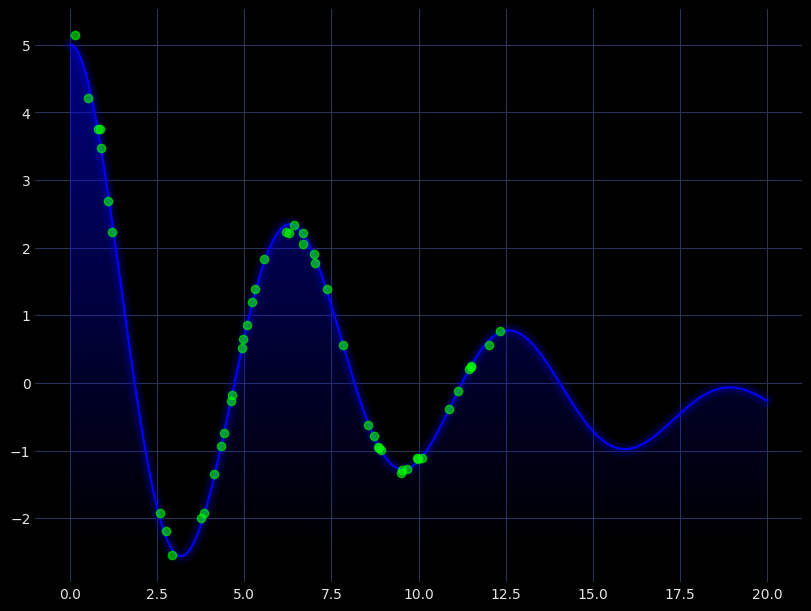

In [155]:
t_values = np.linspace(0, 20, 1001)
oscillator_function = sp.lambdify(t, oscillator_sol.rhs, 'numpy')

datapoints = {'t': np.random.uniform(0, 12.5, 50)}
datapoints['x'] = (x_true := oscillator_function(datapoints['t'])) + np.random.normal(0, np.abs(x_true) * 0.05)

with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.plot(t_values, oscillator_function(t_values), color='blue')
    axes.scatter(datapoints['t'], datapoints['x'], color='lime', zorder=10, alpha=0.6)
    # axes.grid()
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.5)

# Creating the models

In [156]:
class ModularNeuralNetwork(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 output_size: int, 
                 layer_sizes: tuple[int] = (), 
                 activation_function: nn.modules.activation = nn.Tanh()):
        super(ModularNeuralNetwork, self).__init__()
        if len(layer_sizes) == 0:
            self.layers = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=output_size),
                activation_function
            )
        elif len(layer_sizes) == 1:
            size = layer_sizes[0]
            self.layers = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=size),
                activation_function,
                nn.Linear(in_features=size, out_features=output_size),
                activation_function
            )
        else:
            layers = []
            for index, layer_size in enumerate(layer_sizes):
                if index == 0:
                    layer = nn.Linear(in_features=input_size, out_features=layer_size)
                else:
                    layer = nn.Linear(in_features=layer_sizes[index - 1], 
                                      out_features=layer_size)
                layers += [layer, activation_function]
            layers += [nn.Linear(in_features=layer_sizes[-1], 
                                 out_features=output_size)]
            self.layers = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [157]:
X = torch.tensor(datapoints['t'], dtype=torch.float32).unsqueeze(dim=1)
y = torch.tensor(datapoints['x'], dtype=torch.float32).unsqueeze(dim=1)
epochs = 10000
learning_rate = 0.01
hidden_layers = 100, 100, 100
NN = ModularNeuralNetwork(input_size=1,
                          output_size=1,
                          layer_sizes=hidden_layers,
                          activation_function=nn.Tanh())
optimizer = torch.optim.Adam(NN.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
loss_array_nn = np.zeros(epochs)
NN.train()
for epoch in range(epochs):
    y_pred = NN(X)
    loss = criterion(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_array_nn[epoch] = loss.item()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Loss: 3.743431329727173
Loss: 0.0023135908413678408
Loss: 0.0014075743965804577
Loss: 0.003767031943425536
Loss: 0.0011469342280179262
Loss: 0.0011306521482765675
Loss: 0.0013985291589051485
Loss: 0.15764756500720978
Loss: 0.001124445698224008
Loss: 0.0050176759250462055


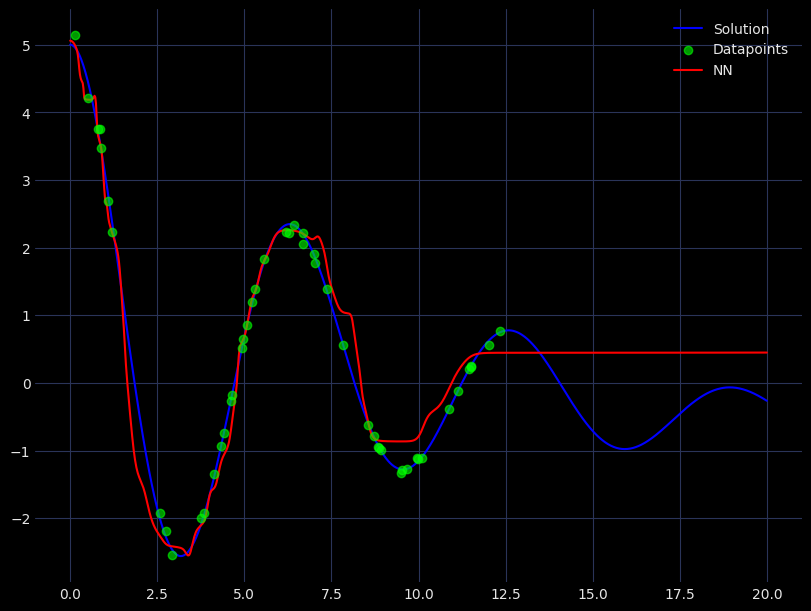

In [158]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.plot(t_values, oscillator_function(t_values), color='blue', label='Solution')
    axes.scatter(datapoints['t'], datapoints['x'], color='lime', label='Datapoints', zorder=10, alpha=0.6)
    t_val_tensor = torch.tensor(t_values, dtype=torch.float32).unsqueeze(dim=1)
    axes.plot(t_val_tensor, NN(t_val_tensor).detach(), color='red', label='NN')
    axes.legend()
    enhance_plot(figure, axes)

In [159]:
X = torch.tensor(datapoints['t'], dtype=torch.float32).unsqueeze(dim=1)
y = torch.tensor(datapoints['x'], dtype=torch.float32).unsqueeze(dim=1)
X_physics = torch.from_numpy(t_values).to(torch.float32).unsqueeze(dim=1).requires_grad_(True)
epochs = 20000
learning_rate = 0.0005
hidden_layers = 200, 200, 200
physics_lambda = 10
PINN = ModularNeuralNetwork(input_size=1,
                            output_size=1,
                            layer_sizes=hidden_layers,
                            activation_function=nn.Tanh())
optimizer = torch.optim.Adam(PINN.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
loss_array_pinn = np.zeros(epochs)
PINN.train()
for epoch in range(epochs):
    y_pred = PINN(X)
    loss1 = criterion(y_pred, y)
    y_physics = PINN(X_physics)
    dx = torch.autograd.grad(
        y_physics, X_physics,
        grad_outputs=torch.ones_like(y_physics),
        create_graph=True)[0]
    dx2 = torch.autograd.grad(
        dx, X_physics,
        grad_outputs=torch.ones_like(dx),
        create_graph=True)[0]
    pde = ((omega_val) * y_physics) + (dx * beta_val_float) + (alpha_val * dx2) - (F_val * torch.cos(Omega_val * X_physics))
    loss2 = physics_lambda * torch.mean(pde ** 2)
    loss = loss1 + loss2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_array_pinn[epoch] = loss.item()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, MSE Loss: {loss1.item()}, Physics Loss: {loss2.item()}')

MSE Loss: 3.7002553939819336, Physics Loss: 1.669290542602539
MSE Loss: 0.2638777792453766, Physics Loss: 0.287293016910553
MSE Loss: 0.04547182098031044, Physics Loss: 0.1668858379125595
MSE Loss: 0.024130599573254585, Physics Loss: 0.10492193698883057
MSE Loss: 0.008385288529098034, Physics Loss: 0.04873953014612198
MSE Loss: 0.0073801446706056595, Physics Loss: 0.044742196798324585
MSE Loss: 0.007019315380603075, Physics Loss: 0.042443402111530304
MSE Loss: 0.0065215593203902245, Physics Loss: 0.035274531692266464
MSE Loss: 0.006101424805819988, Physics Loss: 0.026192402467131615
MSE Loss: 0.005636120215058327, Physics Loss: 0.013509973883628845
MSE Loss: 0.005292853340506554, Physics Loss: 0.003116457024589181
MSE Loss: 0.005228500813245773, Physics Loss: 0.0004230540944263339
MSE Loss: 0.005227388348430395, Physics Loss: 0.00014762516366317868
MSE Loss: 0.005221522878855467, Physics Loss: 0.0001852188288467005
MSE Loss: 0.005482011009007692, Physics Loss: 0.0013348995707929134
MSE

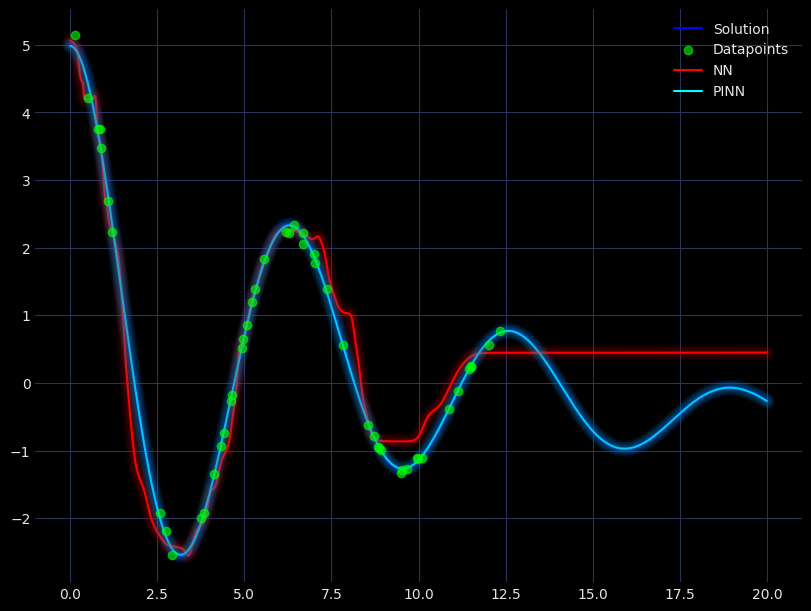

In [161]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.plot(t_values, oscillator_function(t_values), color='blue', label='Solution')
    axes.scatter(datapoints['t'], datapoints['x'], color='lime', label='Datapoints', zorder=10, alpha=0.6)
    t_val_tensor = torch.tensor(t_values, dtype=torch.float32).unsqueeze(dim=1)
    axes.plot(t_val_tensor, NN(t_val_tensor).detach(), color='red', label='NN')
    axes.plot(t_val_tensor, PINN(t_val_tensor).detach(), color='cyan', label='PINN')
    axes.legend()
    enhance_plot(figure, axes, glow=True)

# Finding parameters $\alpha$, $\beta$, $\omega$, $F$, $\Omega$

In [165]:
class OscillatorApproximator(ModularNeuralNetwork):
    def __init__(self,
                 input_size: int,
                 output_size: int,
                 layer_sizes:tuple[int] = (),
                 activation_function: nn.Module = nn.Tanh()):
        super(OscillatorApproximator, self).__init__(
            input_size, output_size,
            layer_sizes=layer_sizes,
            activation_function=activation_function
        )
        self.alpha = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)
        self.beta = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)
        self.omega = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)
        self.F = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)
        self.Omega = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)

In [166]:
X = torch.tensor(datapoints['t'], dtype=torch.float32).unsqueeze(dim=1)
y = torch.tensor(datapoints['x'], dtype=torch.float32).unsqueeze(dim=1)
X_physics = torch.from_numpy(t_values).to(torch.float32).unsqueeze(dim=1).requires_grad_(True)
epochs = 25000
learning_rate = 0.0001
hidden_layers = 200, 200, 200
physics_lambda = 10
Approximator = OscillatorApproximator(
    input_size=1,
    output_size=1,
    layer_sizes=hidden_layers,
    activation_function=nn.Tanh())
optimizer = torch.optim.Adam(Approximator.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
loss_array_app = np.zeros(epochs)
Approximator.train()
for epoch in range(epochs):
    y_pred = Approximator(X)
    loss1 = criterion(y_pred, y)
    y_physics = Approximator(X_physics)
    dx = torch.autograd.grad(
        y_physics, X_physics,
        grad_outputs=torch.ones_like(y_physics),
        create_graph=True)[0]
    dx2 = torch.autograd.grad(
        dx, X_physics,
        grad_outputs=torch.ones_like(dx),
        create_graph=True)[0]
    pde = (Approximator.omega * y_physics) + (dx * Approximator.beta) + (Approximator.alpha * dx2) - (Approximator.F * torch.cos(Approximator.Omega * X_physics))
    loss2 = physics_lambda * torch.mean(pde ** 2)
    loss = loss1 + loss2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_array_app[epoch] = loss.item()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, MSE Loss: {loss1.item()}, Physics Loss: {loss2.item()}')

Epoch 0, MSE Loss: 3.545980215072632, Physics Loss: 0.012070411816239357
Epoch 1000, MSE Loss: 0.38391682505607605, Physics Loss: 0.10828614234924316
Epoch 2000, MSE Loss: 0.07778536528348923, Physics Loss: 0.04043973609805107
Epoch 3000, MSE Loss: 0.018917521461844444, Physics Loss: 0.01828751713037491
Epoch 4000, MSE Loss: 0.01154117938131094, Physics Loss: 0.011356936767697334
Epoch 5000, MSE Loss: 0.009362513199448586, Physics Loss: 0.01006937026977539
Epoch 6000, MSE Loss: 0.006938213016837835, Physics Loss: 0.007401928771287203
Epoch 7000, MSE Loss: 0.005031383130699396, Physics Loss: 0.003591769142076373
Epoch 8000, MSE Loss: 0.003983238711953163, Physics Loss: 0.0007112172315828502
Epoch 9000, MSE Loss: 0.004941574297845364, Physics Loss: 1.0491040697472984e-30
Epoch 10000, MSE Loss: 0.0014133565127849579, Physics Loss: 0.0
Epoch 11000, MSE Loss: 0.0012841708958148956, Physics Loss: 0.0
Epoch 12000, MSE Loss: 0.00123287970200181, Physics Loss: 0.0
Epoch 13000, MSE Loss: 0.00118

In [167]:
Approximator.alpha, Approximator.beta, Approximator.omega, Approximator.F, Approximator.Omega

(Parameter containing:
 tensor([-3.8583e-11], requires_grad=True),
 Parameter containing:
 tensor([-3.0236e-11], requires_grad=True),
 Parameter containing:
 tensor([3.2234e-11], requires_grad=True),
 Parameter containing:
 tensor([-2.5413e-11], requires_grad=True),
 Parameter containing:
 tensor([0.6797], requires_grad=True))